In [1]:
import duckdb
import os
import polars as pl
import polars.selectors as cs

import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup 
import markdown
import requests
import re
import concurrent.futures

from markdownify import markdownify as md

from lib.models import Post,Section
from lib.transform import transform_api_results
from lib.tree_functions import import_tree_from_json, find_node_by_id
from lib.config import pipeline_name, db_name, tree_json_path, download_subpage

from selenium import webdriver
from selenium.webdriver.common.by import By

import time

In [2]:
root_node = import_tree_from_json(tree_json_path)
print(root_node)

AnyNode(data_id='36', data_level='0', data_parent_id='0', name='Pimp my School Downloads')


In [3]:
df = transform_api_results(pipeline_name, db_name)

50


In [4]:
df.head()

id,date,title,content,stage,topics,tool_types
i64,"datetime[μs, Europe/Berlin]",str,str,str,list[str],list[str]
5821,2022-05-30 00:00:00 CEST,"""Ideen Öffentlichkeitsarbeit""",""" <div data-elementor-type=""wp…","""grundlagen""","[""oeffentlichkeitsarbeit""]","[""praesentation""]"
6199,2022-10-04 00:00:00 CEST,"""Wie schülerfreundlich sind uns…",""" <div data-elementor-type=""wp…","""sv-alltag""","[""ideenfindung"", ""motivation"", … ""zeitmanagement""]","[""selbsttest""]"
6552,2022-12-08 00:00:00 CET,"""SV-Profile""",""" <div data-elementor-type=""wp…","""sv-alltag""","[""ideenfindung"", ""motivation"", … ""zeitmanagement""]","[""selbsttest""]"
6008,2022-06-09 00:00:00 CEST,"""Rechte Thüringen""",""" <div data-elementor-type=""wp…","""grundlagen""","[""rechte""]","[""praesentation""]"
8151,2025-07-22 00:00:00 CEST,"""Rechte Quiz NRW""",""" <div data-elementor-type=""wp…","""grundlagen""","[""rechte-nrw""]","[""praesentation""]"


In [ ]:
df["stage"].value_counts().sort("count", descending=True)

stage,count
str,u32
"""grundlagen""",22
null,11
"""sv-alltag""",6
"""profis""",6
"""fortgeschrittene""",5


In [6]:
df["stage"].unique().to_list()

['sv-alltag', 'grundlagen', None, 'fortgeschrittene', 'profis']

In [7]:
df["tool_types"].value_counts().sort("count", descending=True)

tool_types,count
list[str],u32
"[""praesentation""]",15
"[""methode""]",10
"[""infografik""]",7
"[""selbsttest""]",5
"[""video""]",4
…,…
"[""vorlage""]",2
"[""methode"", ""vorlage""]",1
"[""infografik"", ""vorlage""]",1


In [8]:
def count_plot(df, col):
    lst = [x for xs in df[col] for x in xs]

    series = pl.Series(col, lst)
    counts_df = (
        pl.DataFrame([series])
        .unpivot()
        .group_by("value")
        .len()
        .sort("len", descending=True)
        .rename({"value": col, "len": "count"})
    )

    sns.barplot(data=counts_df, y=col, x="count", order=counts_df[col])
    plt.show()

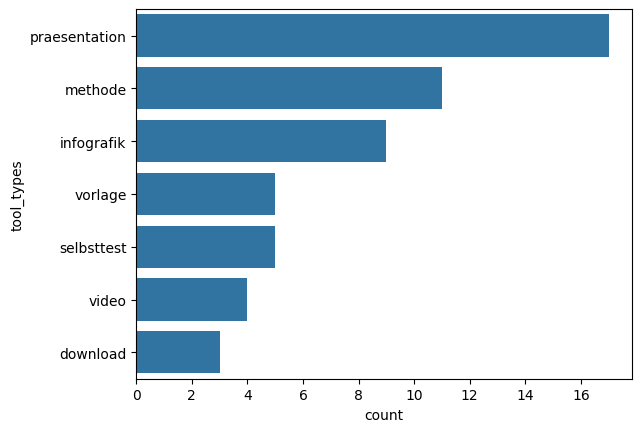

In [9]:
count_plot(df, "tool_types")

In [10]:
lst = [x for xs in df["tool_types"] for x in xs]
list(set(lst))

['praesentation',
 'methode',
 'video',
 'download',
 'vorlage',
 'selbsttest',
 'infografik']

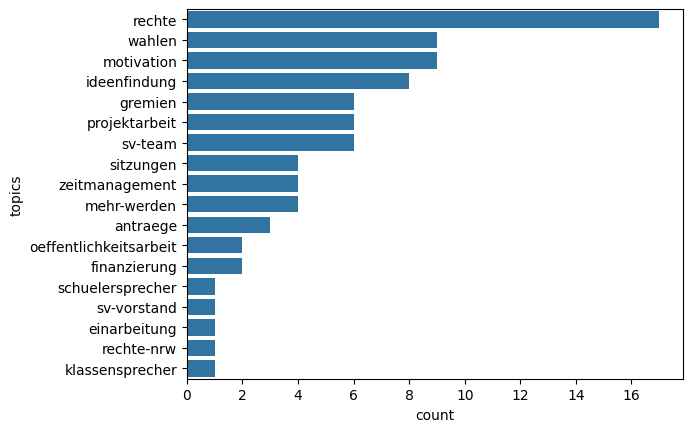

In [11]:
count_plot(df, "topics")

In [12]:
section_df["type"].value_counts()

NameError: name 'section_df' is not defined

### Download File Types

In [ ]:
with duckdb.connect(f"{pipeline_name}.duckdb", read_only=False) as db:
    df_downloads = db.sql(f"SELECT * FROM {db_name}.downloads").pl()

assert len(df_downloads) == len(df_downloads["data_id"].unique())

df_downloads["file_type"].value_counts()

file_type,count
str,u32
"""mp4""",4
"""pdf""",57
"""octet-stream""",12
"""png""",1
"""jpeg""",3
